In [1]:
!pip install scikit-posthocs
!pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.1 MB/s eta 0:00:00


In [2]:
import zipfile

# Define the path to the zip file
zip_path = "/content/Data for modelling.zip"
extract_path = "/content/Data_for_modelling"  # Folder to extract files

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [92]:
import pandas as pd
import numpy as np
ticker = 'BVSP'
df = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Emerging/BVSP/{ticker}.csv', index_col=0)
data = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Emerging/BVSP/{ticker}_return.csv')

data.index = df['Date']
data = data.dropna()

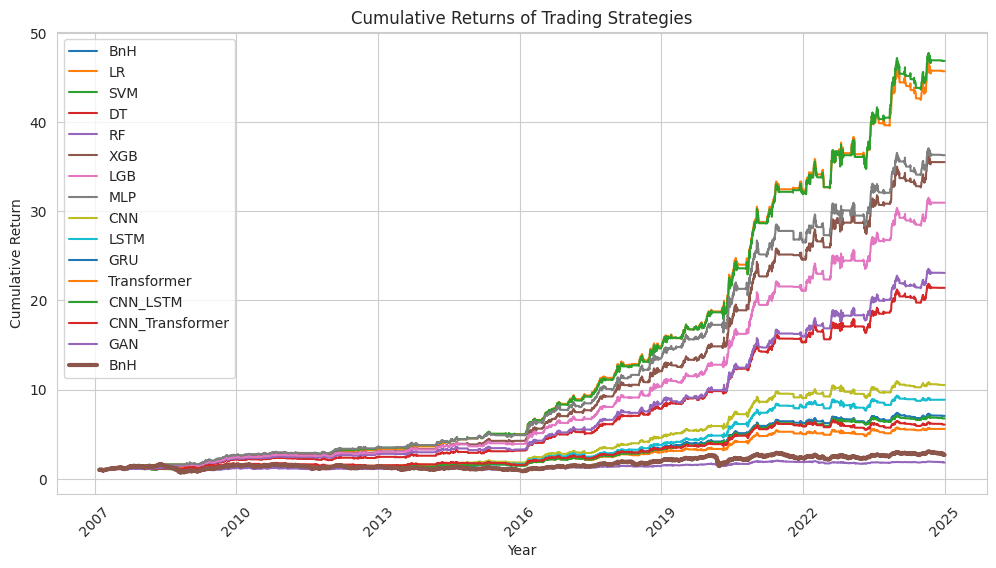

In [93]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure index is datetime
data.index = pd.to_datetime(data.index)

# Compute cumulative returns
cumulative_returns = (1 + data).cumprod()

# Plot
plt.figure(figsize=(12, 6))

for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.plot(cumulative_returns.index, cumulative_returns['BnH'], label='BnH', linewidth=3)

plt.title('Cumulative Returns of Trading Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()

# Format x-axis to show only years
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))  # Show every 3 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as YYYY
plt.xticks(rotation=45)  # Rotate labels if needed

plt.legend()
plt.title('Cumulative Returns of Trading Strategies')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.grid()
plt.savefig(f'/content/Data_for_modelling/Data for modelling/Emerging/BVSP/{ticker}_1.png')

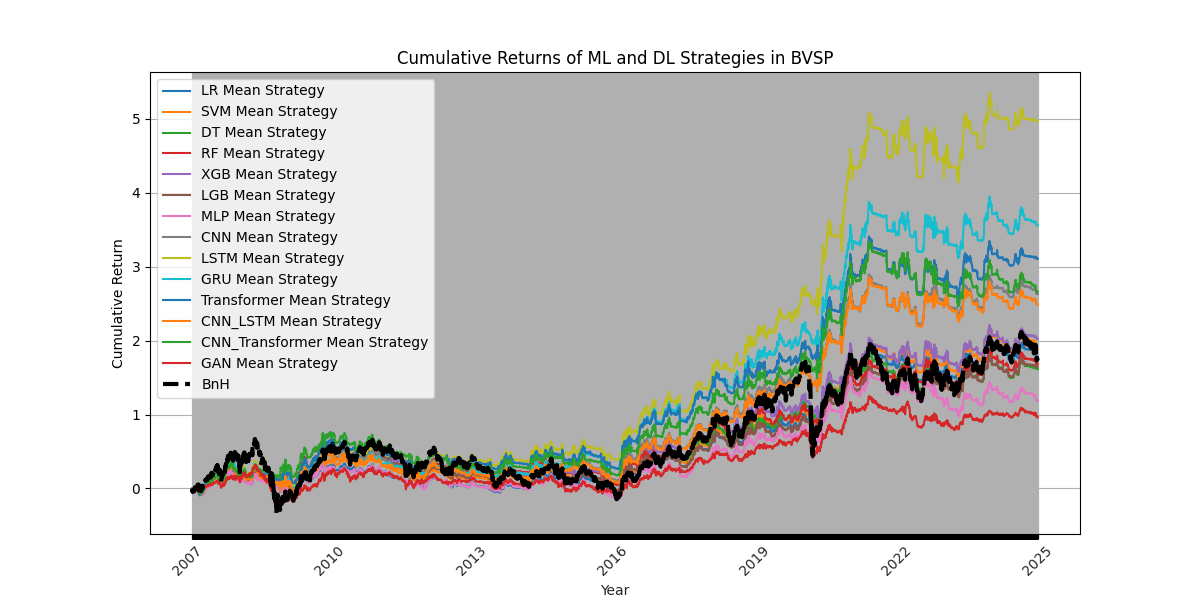

In [94]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import for Colab

# Load the two images
first_image = cv2.imread(f'/content/Data_for_modelling/Data for modelling/Emerging/BVSP/{ticker}.png')   # Update path
second_image = cv2.imread(f'/content/Data_for_modelling/Data for modelling/Emerging/BVSP/{ticker}_1.png') # Update path

# Convert images to grayscale to detect the date axis
gray_second = cv2.cvtColor(second_image, cv2.COLOR_BGR2GRAY)

# Crop the date axis from the second image (adjust if needed)
y_start = int(second_image.shape[0] * 0.9)  # Lower 10% contains the date axis
date_axis = second_image[y_start:, :]

# Remove the incorrect date axis from the first image (set that region to white)
first_image[y_start:, :] = 255  # White background

# Overlay the new date axis onto the first image
first_image[y_start:, :] = date_axis

# Save and display the fixed image
cv2.imwrite(f'/content/Data_for_modelling/Data for modelling/Frontier/VNI/{ticker}_final.png', first_image)
cv2_imshow(first_image)  # Use this instead of cv2.imshow()


# **Compare return**

In [95]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Reshape data: Convert from wide format to long format
data_long = data.reset_index().melt(id_vars="Date", var_name="model", value_name="daily_return")

# Get unique models (including 'BnH')
models = data.columns.tolist()

# Convert data to the format required for Kruskal-Wallis test
returns_data = [data[model].dropna().values for model in models]  # Drop NaNs

# Perform Kruskal-Wallis test
print("\n📊 Performing Kruskal-Wallis test on daily returns...\n")
test_stat, p_value = stats.kruskal(*returns_data)

# Display Kruskal-Wallis test result
if p_value < 0.05:
    print(f"⚠️ Kruskal-Wallis Test Result: p={p_value:.4f} → Significant Difference Found!")

    # Perform Nemenyi post-hoc test
    nemenyi_test = sp.posthoc_nemenyi(data_long, val_col="daily_return", group_col="model")

    # Format Nemenyi results to 4 decimal places
    nemenyi_test = nemenyi_test.map(lambda x: f"{x:.4f}")

    # Display Nemenyi test results
    print("\n📊 Nemenyi Test Results for Daily Returns:\n")
    print(nemenyi_test.to_string(index=True))
else:
    print(f"✅ No significant difference found (p={p_value:.4f})")




📊 Performing Kruskal-Wallis test on daily returns...

✅ No significant difference found (p=0.3622)


In [96]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Calculate daily return statistics for each model
summary_stats = pd.DataFrame(index=data.columns)

summary_stats['Mean_Return'] = data.mean()  # Mean daily return
summary_stats['Std_Dev'] = data.std()  # Standard deviation (volatility)
summary_stats['Skewness'] = data.apply(skew)  # Skewness (asymmetry)
summary_stats['Kurtosis'] = data.apply(kurtosis)  # Kurtosis (tail risk)

# Display results rounded to 4 decimal places
print(summary_stats.round(4))

                 Mean_Return  Std_Dev  Skewness  Kurtosis
BnH                   0.0004   0.0169   -0.1267    9.4914
LR                    0.0009   0.0091    0.7007    7.3307
SVM                   0.0009   0.0091    0.7005    7.3663
DT                    0.0007   0.0093    0.4712    7.5940
RF                    0.0008   0.0092    0.5014    7.4873
XGB                   0.0009   0.0091    0.6849    6.9283
LGB                   0.0008   0.0092    0.6323    6.9783
MLP                   0.0009   0.0090    0.6676    6.9388
CNN                   0.0006   0.0099    0.4908    8.6171
LSTM                  0.0005   0.0101    0.1825    9.4834
GRU                   0.0005   0.0098    0.0758    8.1113
Transformer           0.0004   0.0099    0.0667    8.4857
CNN_LSTM              0.0005   0.0098    0.1221    8.3520
CNN_Transformer       0.0005   0.0096    0.0763    8.2133
GAN                   0.0002   0.0089    0.2495   12.9798


In [97]:
metrics = ['Total Return [%]', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown [%]']
performance = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Emerging/BVSP/{ticker}_trading.csv', index_col=0)
print(performance.loc[metrics])

                                  LR                 SVM                  DT  \
Total Return [%]  176.17854246745716  188.60853540603836  161.31826422317764   
Sharpe Ratio      0.5138557230971332  0.5309030445324733  0.4891574674520381   
Sortino Ratio     0.7421402656729726  0.7687726341653915  0.7054602748879024   
Max Drawdown [%]  38.184826763409056   38.64933112595768  37.911788638271105   

                                  RF                 XGB                  LGB  \
Total Return [%]  167.88991973611905  202.55680370337433    164.1227100119713   
Sharpe Ratio      0.5041922342278672  0.5554228793433089  0.49645968515067046   
Sortino Ratio     0.7273205108466427  0.8043305553649328   0.7153343351722838   
Max Drawdown [%]  40.258902442259725  39.595781558396695    41.50136151438458   

                                 MLP                 CNN                LSTM  \
Total Return [%]  118.71879416827885    263.003202176656   496.2473135804627   
Sharpe Ratio       0.411558340480

In [98]:
import vectorbt as vbt
bnh = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Emerging/BVSP/{ticker}.csv', index_col=0)
bnh.index = bnh['Date']
bnh['signal'] = [1]*len(bnh)

In [99]:
data['close'] = bnh['close']
data['signal'] = bnh['signal']

In [100]:
p1 = vbt.Portfolio.from_signals(
        close=bnh['close'],
        entries=bnh.signal==1,  # Entries where signal is 1
        exits=bnh.signal == 0,  # Exits where signal is 0
        size=1,  # Assuming equal position size
        fixed_fees=0.001,  # Example transaction cost
        slippage=0.001,
        freq='1d'
    )
p1.stats(agg_func=None).T.loc[metrics]

,0
Total Return [%],172.970549
Sharpe Ratio,0.420097
Sortino Ratio,0.595833
Max Drawdown [%],59.961642


# **Accuracy**

In [101]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
import numpy as np
import os

# Define parameters
models = ['LR', 'SVM', 'DT', 'RF', 'XGB', 'LGB', 'MLP',
          'CNN', 'LSTM', 'GRU', 'Transformer',
          'CNN_LSTM', 'CNN_Transformer', 'GAN']

base_path = "/content/Data_for_modelling/Data for modelling/Emerging/BVSP/"


# Load all model data into a single DataFrame
data_list = []
for model in models:
    file_path = os.path.join(base_path, f"{ticker}_{model}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['model'] = model  # Add model name column
        data_list.append(df)
        print(f"✅ Loaded {model} data successfully.")
    else:
        print(f"⚠️ {model} file not found at {file_path}. Skipping.")

# Merge all data
data = pd.concat(data_list, ignore_index=True)

# Get metric columns (excluding 'ticker' and 'model')
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'MCC', 'AUC']

# Store results
kruskal_results = {}
nemenyi_results = {}

# Loop through each metric
for metric in metrics:
    print(f"\n📊 Performing Kruskal-Wallis test for {metric}...\n")

    # Extract values for all models
    metric_values = [data[data['model'] == model][metric] for model in models if model in data['model'].unique()]

    # Perform Kruskal-Wallis test
    test_stat, p_value = stats.kruskal(*metric_values)

    # Store Kruskal-Wallis results
    kruskal_results[metric] = {'p_value': p_value}

    # Print Kruskal-Wallis results
    if p_value < 0.05:
        print(f"⚠️ Kruskal-Wallis Result: p={p_value:.4f} → Significant Difference!")

        # Perform Nemenyi post-hoc test (Corrected version)
        nemenyi_test = sp.posthoc_nemenyi(data, val_col=metric, group_col='model')

        # Store Nemenyi results
        nemenyi_results[metric] = nemenyi_test

        print(f"\n📊 Nemenyi Test Results for {metric}:\n")
        print(nemenyi_test.round(4))
    else:
        print(f"✅ No significant difference found (p={p_value:.4f})")

# Print summary of Kruskal-Wallis tests
print("\n🔹 Summary of Kruskal-Wallis Test Results:")
kruskal_summary_df = pd.DataFrame(kruskal_results).T
print(kruskal_summary_df.round(4))

# Print summary of Nemenyi test results (if any)
if nemenyi_results:
    print("\n🔹 Summary of Nemenyi Test Results:")
    for metric, result in nemenyi_results.items():
        print(f"\n📊 Nemenyi test for {metric}:\n")
        print(result.round(4))

✅ Loaded LR data successfully.
✅ Loaded SVM data successfully.
✅ Loaded DT data successfully.
✅ Loaded RF data successfully.
✅ Loaded XGB data successfully.
✅ Loaded LGB data successfully.
✅ Loaded MLP data successfully.
✅ Loaded CNN data successfully.
✅ Loaded LSTM data successfully.
✅ Loaded GRU data successfully.
✅ Loaded Transformer data successfully.
✅ Loaded CNN_LSTM data successfully.
✅ Loaded CNN_Transformer data successfully.
✅ Loaded GAN data successfully.

📊 Performing Kruskal-Wallis test for Accuracy...

⚠️ Kruskal-Wallis Result: p=0.0000 → Significant Difference!

📊 Nemenyi Test Results for Accuracy:

                    CNN  CNN_LSTM  CNN_Transformer      DT     GAN     GRU  \
CNN              1.0000    1.0000           0.9986  0.3138  0.0000  0.9971   
CNN_LSTM         1.0000    1.0000           1.0000  0.8957  0.0007  1.0000   
CNN_Transformer  0.9986    1.0000           1.0000  0.9797  0.0045  1.0000   
DT               0.3138    0.8957           0.9797  1.0000  0.6176

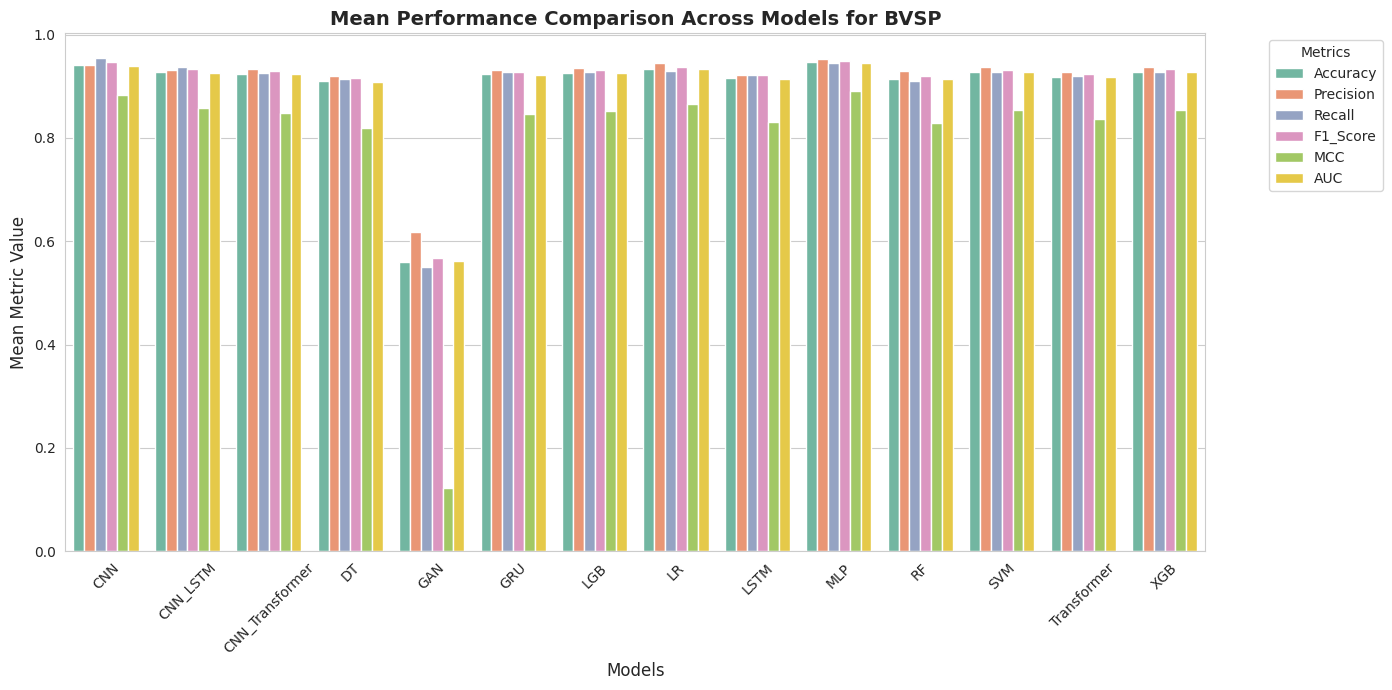

In [102]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
import os
import matplotlib.pyplot as plt
import seaborn as sns
mean_performance = data.groupby('model')[metrics].mean().reset_index()

plt.figure(figsize=(14, 7))

# Reshape the data for Seaborn
data_melted = mean_performance.melt(id_vars=['model'], value_vars=metrics, var_name='Metric', value_name='Mean Value')

# Create a grouped bar plot
sns.set_style("whitegrid")
ax = sns.barplot(x='model', y='Mean Value', hue='Metric', data=data_melted, palette="Set2")

# Rotate x-axis labels for readability
plt.xticks(rotation=45)
plt.title(f"Mean Performance Comparison Across Models for {ticker}", fontsize=14, fontweight='bold')
plt.xlabel("Models", fontsize=12)
plt.ylabel("Mean Metric Value", fontsize=12)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [103]:
mean_performance.round(4)

,model,Accuracy,Precision,Recall,F1_Score,MCC,AUC
0,CNN,0.9421,0.9404,0.9548,0.9469,0.8840,0.9395
1,CNN_LSTM,0.9279,0.9314,0.9380,0.9329,0.8571,0.9257
2,CNN_Transformer,0.9239,0.9337,0.9254,0.9289,0.8474,0.9231
3,DT,0.9100,0.9192,0.9140,0.9162,0.8187,0.9090
4,GAN,0.5597,0.6187,0.5506,0.5679,0.1228,0.5627
5,GRU,0.9237,0.9310,0.9280,0.9287,0.8470,0.9220
6,LGB,0.9265,0.9355,0.9275,0.9313,0.8518,0.9258
7,LR,0.9333,0.9454,0.9296,0.9373,0.8657,0.9333
8,LSTM,0.9161,0.9211,0.9222,0.9212,0.8308,0.9142
9,MLP,0.9461,0.9538,0.9458,0.9495,0.8919,0.9459
